In [1]:
novel_to_analyze = 'Armadale.txt'
novel_name = novel_to_analyze.split('.')[0]
print(novel_name)
## to all spreadsheets:
path_to_spreadsheets = '../../../data/spreadsheets/'

Armadale


In [2]:
import codecs
import os
import pandas as pd
# to be able to see more columns when dataframes are printed out:
# pd.set_option('display.max_columns', 100)
pd.set_option('display.max_columns', 1000,'display.max_colwidth', None, 'display.width', 1000, 'display.max_rows',1000)
# to not get copy warnings when splitting dataframes
pd.options.mode.chained_assignment = None
# required to not process symbols (like "$") as MathJax
# https://stackoverflow.com/questions/52550355/how-do-i-get-rid-of-italics-in-ipython-pandas-and-get-plain-text
pd.set_option('display.html.use_mathjax', False)
import re
import spacy
import sys
import numpy as np

import matplotlib.pyplot as plt
import random
import nltk
nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('tagsets')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
# Vis:
# import matplotlib
# import cufflinks as cf
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)


# cf.go_offline() # required to use plotly offline (no account required).


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [3]:
## to Newpaper Novel corpus:
path_to_nnovels_corpus = '../../../data/corpora/corpus_newspaper_novels/' 

## to assets:
path_to_assets = '../../../assets/'
## characters and numbers to exclude from texts:
exclude_file = 'characters_and_numbers_to_exclude.txt'

# characters to exclude
with codecs.open(path_to_assets + exclude_file, 'r', encoding='utf-8', errors="ignore") as characters_to_exclude_raw:
    characters_to_exclude = characters_to_exclude_raw.read()
    characters_to_exclude = characters_to_exclude.split()

print(characters_to_exclude)
characters_to_exclude_edited = ['<', '*', '-', ']', '~', ',', '{', '$', '+', '[', '|', '_', '@', '(', '%', '^', '/', '\\\\', '&', '#', '>', '}', '=', ')']

['<', '*', '-', ']', '~', ',', '{', '$', '+', '[', '"', '|', '_', '@', '(', "'", '%', '^', '/', '\\\\', '&', '#', '>', '}', '`', '=', ')', '”', '“', '‘', '’', '3', '6', '2', '1', '5', '7', '4', '8', '9', '0']


In [4]:
with codecs.open(path_to_nnovels_corpus + novel_to_analyze, 'r', encoding='utf-8', errors="ignore") as raw_text:
    dirty_text = raw_text.read()

prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
dashes = "(--)+"

dirty_text = re.sub(prefixes,"\\1<prd>", dirty_text)
dirty_text = re.sub(dashes, ' \\1 ', dirty_text)
dirty_text = re.sub('(“|”)', '"', dirty_text)
clean_text_list = sent_tokenize(dirty_text)

clean_sentences = []
for sent in clean_text_list:
    # res.append(re.sub('\n', '', sent))
    # removing newline notations
    clean_sent = re.sub('\n', ' ', sent)
    clean_sent = re.sub('\r', ' ', clean_sent)
    # transforming multiple spaces to one space
    clean_sent = re.sub('\s+',' ', clean_sent)
    clean_sentences.append(clean_sent)
    


In [5]:
text_dict = {"sentences":clean_sentences}
df = pd.DataFrame.from_dict(text_dict)
df.head()

sentences
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           THE TRAVELERS.
1                                                                                                                                                                                                                                                                                                                                                                                                                                            It was the opening of the season of eighteen hundred and thirty-two, at the Baths of Wildbad.
2                                                                                                                                                                                                                                                                                                                                                                                                             The evening shadows were beginning to gather over the quiet little German town, and the diligence was expected every minute.
3                                                                                                                                                                                                                       Before the door of the principal inn, waiting the arrival of the first visitors of the year, were assembled the three notable personages of Wildbad, accompanied by their wives -- the mayor, representing the inhabitants; the doctor, representing the waters; the landlord, representing his own establishment.
4  Beyond this select circle, grouped snugly about the trim little square in front of the inn, appeared the towns-people in general, mixed here and there with the country people, in their quaint German costume, placidly expectant of the diligence -- the men in short black jackets, tight black breeches, and three-cornered beaver hats; the women with their long light hair hanging in one thickly plaited tail behind them, and the waists of their short woolen gowns inserted modestly in the region of their shoulder-blades.

In [6]:
df['is_upper'] = 0
for index, row in df.iterrows():
    text = row['sentences']
    if text.isupper():
        df.at[index, 'is_upper'] = 1
df = df[df.is_upper != 1]
df = df.drop('is_upper', 1)
df['narration_is_0_dialogue_is_1'] = 0
# df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [7]:
dialogue_started = False
for index, row in df.iterrows():
    sent = row['sentences']
    sent = ''.join(char for char in sent if char not in characters_to_exclude_edited)
    sent = sent.strip()
    df.at[index, 'sentences'] = sent
    
    # sent = row['sentences']
    if sent.startswith('"'):
        dialogue_started = True
    if dialogue_started:
        df.at[index, 'narration_is_0_dialogue_is_1'] = 1

        if sent.endswith('"'):
            dialogue_started = False
            
        else:
            continue
    else:
        df.at[index, 'narration_is_0_dialogue_is_1'] = 0

In [8]:
# df.head(-5)

In [9]:
# placing back all the periods once sentence is tokenized
prd_replace = "<prd>"

for index, row in df.iterrows():
    text = row['sentences']
    text = re.sub(prd_replace,".", text)
    df.at[index, 'sentences'] = text
    

In [10]:
# df.head(-5)

In [11]:
# Getting sentence lengths
df["sentence_length"] = 0
for index, row in df.iterrows():
    sentences = row["sentences"].split()
    # removing empty list elements
    filtered_list = list(filter(None, sentences))
    df.at[index, "sentence_length"] = len(filtered_list)
    

In [12]:
# df.head(5)

In [13]:
# SPACY
# https://machinelearningknowledge.ai/tutorial-on-spacy-part-of-speech-pos-tagging/
# https://blog.ekbana.com/nlp-for-beninners-using-spacy-6161cf48a229
# https://www.geeksforgeeks.org/python-pos-tagging-and-lemmatization-using-spacy/
# https://spacy.io/usage/linguistic-features
# spacy.explain("VBZ")


# NLTK
# https://www.nltk.org/book/ch05.html
# https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
# See all tags:
# nltk.help.upenn_tagset()
# https://stackoverflow.com/questions/30821188/python-nltk-pos-tag-not-returning-the-correct-part-of-speech-tag/30823202#30823202

In [14]:
## POS tagging: copy
## https://machinelearningknowledge.ai/tutorial-on-spacy-part-of-speech-pos-tagging/
def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))
    percents = round(100.1 * count / float(total), 1)
    bar = '#' * filled_len + '-' * (bar_len - filled_len)
    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush() 
    
# first loading english language support
nlp = spacy.load("en_core_web_sm")

## Takes in a dataframe and clean text column (as string), and returns the df with POS tags for all the texts
## Multiple columns are created, one for each POS tag, and one that contains all POS tags (I did this to more easily
## be able to grab POS percentages afterward)
def get_POS_tags_for_text_in_df(df, text_row_to_analyze='sentences'):
    # setting up column for pos counts
    df['tagged_sentence'] = ''
    df['all_pos_counts'] = ''
    df["parts_of_speech_total_count"] = ''
    # loop through df and get all POS tags:
    for index, row in df.iterrows():
        # show progress
        progress(index, len(df.index))
        
        # grab text
        text = row[text_row_to_analyze]
        
        # this is a memory buffer, to extend max length of available ram according to the text being analyzed
        # https://datascience.stackexchange.com/questions/38745/increasing-spacy-max-nlp-limit
        nlp.max_length = len(text) + 100
        
        # disable modules not in use to save memory
        analyzed_doc = nlp(text, disable = ['ner'])
        words_and_tags = []
        
        # getting the complete tokenized sentence
        for token in analyzed_doc:
            tagged_word = (token, token.tag_)
            words_and_tags.append(tagged_word)
            
            
        # grabbing all pos counts in the text in non-human readable format
        pos_counts_in_text = analyzed_doc.count_by(spacy.attrs.IDS['TAG'])
        
        # setting up list to render pos hashes in human readable format:
        human_readable_pos_count_list = []
        
        # iterating through counts to make hashes human readable:
        for tag, count in pos_counts_in_text.items():
            human_readable_tag = analyzed_doc.vocab[tag].text
            # rendering as list to input back into df
            human_readable_tag_and_count = (human_readable_tag, count)
            human_readable_pos_count_list.append(human_readable_tag_and_count)
            
        # looping through the human readable counts, assigning their label to the column
        # and the count to the row for each pos tag
        for element in human_readable_pos_count_list:
            df.at[index, str(element[0])+'_POS_count'] = element[1]
        
        # placing all the pos counts for each text in the all_pos_counts column
        df.at[index, 'all_pos_counts'] = human_readable_pos_count_list
        df.at[index, 'tagged_sentence'] = words_and_tags
        
    df = df.fillna(0)
    # getting POS percentages for each POS tag in texts
    # There are much easier and more efficient ways to do this rather than looping over the entire df again but we were pressed for time...
    # TODO: integrate this loop into previous loop
    for index, row in df.iterrows():
        total = 0.0
        for name in df.columns.values.tolist():
            if not name.startswith("%"):
                if name.endswith("_POS_count"):
                    # get total POS elements count for sanity
                    total += row[name]
        try:
            df.at[index, "parts_of_speech_total_count"] = int(total)
        except Exception as e:
            print(e)
        for name in df.columns.values.tolist():
            if not name.startswith("%"):
                if name.endswith("_POS_count"):
                    # assign new name for column
                    new_name = "%" + name
                    # get % of total POS in text
                    if total != 0:
                        percentage = round((row[name] / total) * float(100), 3)
                    else:
                        print(row[text_row_to_analyze])
                    # if this is the first index, create the column name to avoid errors
                    if index == 0:
                        df[new_name] = 0.0
                    df.at[index, new_name] = percentage
    return df

In [15]:
# analyze df
df = get_POS_tags_for_text_in_df(df, text_row_to_analyze='sentences')


In [16]:
df.head()

sentences  narration_is_0_dialogue_is_1  sentence_length  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                 It was the opening of the season of eighteen hundred and thirtytwo at the Baths of Wildbad.                             0               17   
2                                                                                                                                                                                                                                                                                                                                                                                                 The evening shadows were beginning to gather over the quiet little German town and the diligence was expected every minute.                             0               20   
3                                                                                                                                                                                                                  Before the door of the principal inn waiting the arrival of the first visitors of the year were assembled the three notable personages of Wildbad accompanied by their wives  the mayor representing the inhabitants; the doctor representing the waters; the landlord representing his own establishment.                             0               45   
4  Beyond this select circle grouped snugly about the trim little square in front of the inn appeared the townspeople in general mixed here and there with the country people in their quaint German costume placidly expectant of the diligence  the men in short black jackets tight black breeches and threecornered beaver hats; the women with their long light hair hanging in one thickly plaited tail behind them and the waists of their short woolen gowns inserted modestly in the region of their shoulderblades.                             0               83   
5                                                                                                                                                      Round the outer edge of the assemblage thus formed flying detachments of plump whiteheaded children careered in perpetual motion; while mysteriously apart from the rest of the inhabitants the musicians of the Baths stood collected in one lost corner waiting the appearance of the first visitors to play the first tune of the season in the form of a serenade.                             0               60   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   tagged_sentence 

In [17]:
tag_lst = nlp.pipe_labels['tagger']

print(len(tag_lst))
print(tag_lst)

49
['$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'ADD', 'AFX', 'CC', 'CD', 'DT', 'EX', 'FW', 'HYPH', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NFP', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', 'XX', '``']


In [19]:
print(df.columns.to_list())
list_of_elements_to_analyze = df.columns.to_list()[5:]

['sentences', 'narration_is_0_dialogue_is_1', 'sentence_length', 'tagged_sentence', 'all_pos_counts', 'parts_of_speech_total_count', 'PRP_POS_count', 'VBD_POS_count', 'DT_POS_count', 'NN_POS_count', 'IN_POS_count', 'CD_POS_count', 'CC_POS_count', 'NNPS_POS_count', 'NNP_POS_count', '._POS_count', 'NNS_POS_count', 'VBG_POS_count', 'TO_POS_count', 'VB_POS_count', 'RP_POS_count', 'JJ_POS_count', 'VBN_POS_count', 'PRP$_POS_count', '_SP_POS_count', ':_POS_count', 'RB_POS_count', 'WDT_POS_count', 'VBZ_POS_count', '``_POS_count', "''_POS_count", 'POS_POS_count', 'VBP_POS_count', 'WP_POS_count', 'FW_POS_count', 'JJR_POS_count', 'UH_POS_count', 'MD_POS_count', 'EX_POS_count', 'WP$_POS_count', 'WRB_POS_count', 'RBR_POS_count', 'JJS_POS_count', 'PDT_POS_count', 'RBS_POS_count', 'LS_POS_count', 'XX_POS_count', 'ADD_POS_count', 'NFP_POS_count', ',_POS_count', '%PRP_POS_count', '%VBD_POS_count', '%DT_POS_count', '%NN_POS_count', '%IN_POS_count', '%CD_POS_count', '%CC_POS_count', '%NNPS_POS_count', '%

VBD: verb, past tense


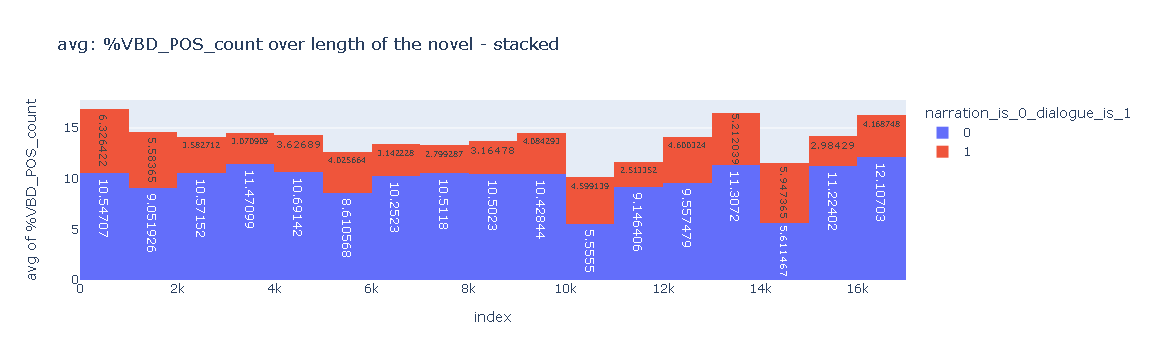

VBG: verb, gerund or present participle


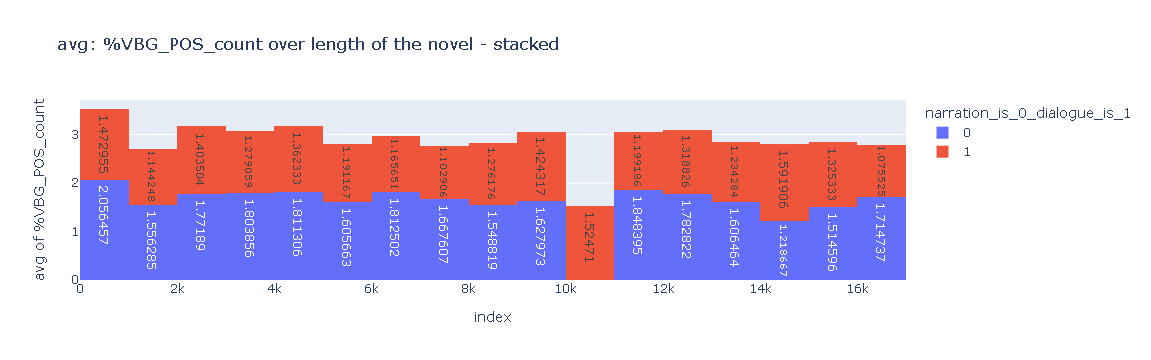

VB: verb, base form


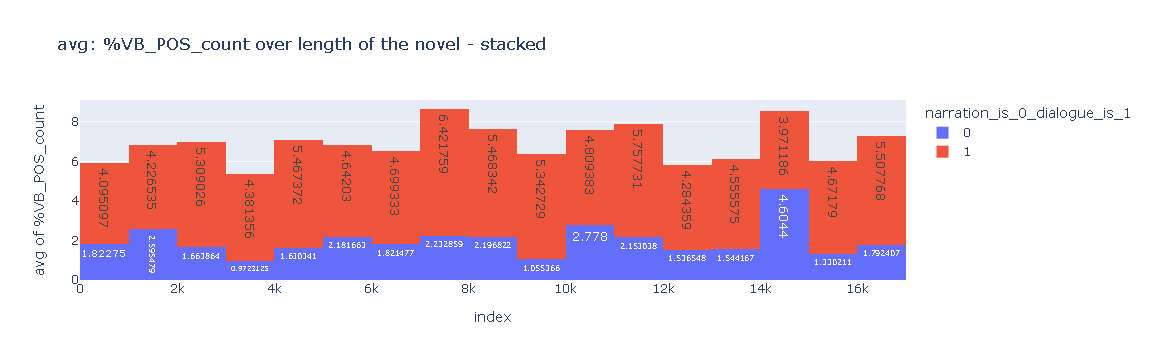

VBN: verb, past participle


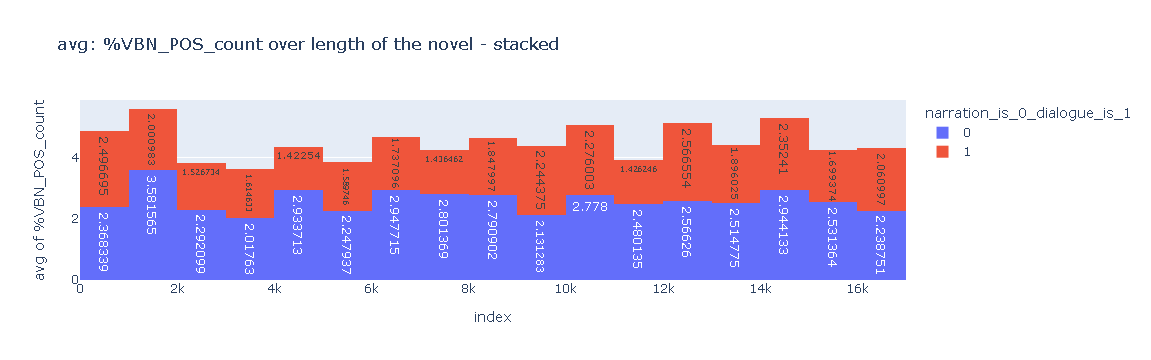

VBZ: verb, 3rd person singular present


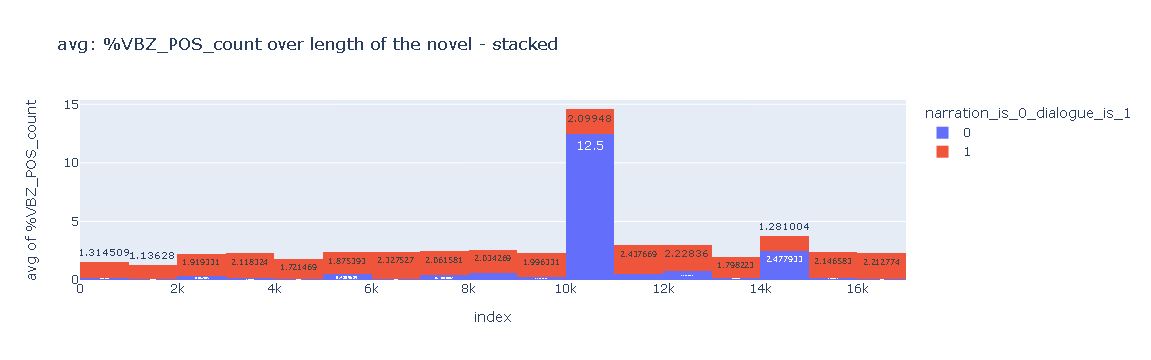

VBP: verb, non-3rd person singular present


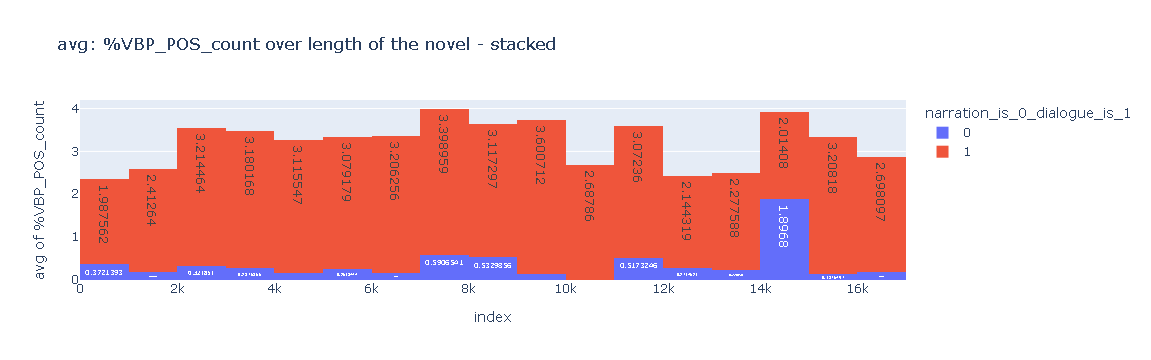

In [29]:
# https://towardsdatascience.com/histograms-with-plotly-express-complete-guide-d483656c5ad7
# https://plotly.com/python/categorical-axes/
for element in list_of_elements_to_analyze:
    if element.startswith("%V"):
        tag = element.split("_")[0].split("%")[1]
        print(f"{tag}: {spacy.explain(tag)}")
        for histfunc in ["avg"]:
            fig = px.histogram(df, 
                               x=df.index,
                               nbins=30,
                               y=element,
                               color="narration_is_0_dialogue_is_1", 
                               barmode='stack',
                               histfunc=histfunc,
                               text_auto=True,
                               # width=1000, 
                               # height=600,
                               title=f"{histfunc}: {element} over length of the novel - stacked")
            fig.show()

In [52]:
### Divide the DF into 5 sections and understand changes that happen in those sections:

N = 5
# columns_in_df = df2.columns.values.tolist()
print(f"Printing out information for {novel_to_analyze}. The DF is split into {N} sections.")
for name in list_of_elements_to_analyze:
    if (name.startswith("%V") | name.startswith("V")):
        try:
            tag = name.split("%")[1].split("_")[0]
        except Exception as es:
            tag = name.split("_")[0]
        print(tag)
        print(f"The POS tag being shown is {name}.", end=': ')
        print(f"{tag}: {spacy.explain(tag)}")
        split_arrays = np.array_split(df[name], N)
        
        for i in range(N):
            mean_of_section = split_arrays[i].mean()
            max_of_section = split_arrays[i].max()
            min_of_section = split_arrays[i].min()
            median_of_section = split_arrays[i].median()
            sum_of_section = split_arrays[i].sum()
            # print(f"SECTION {i}: The MEAN value is: {mean_of_section}. The MAX value is: {max_of_section}. The MIN value is: {min_of_section}. The MEDIAN value is: {median_of_section}. The SUM value is {sum_of_section}")
            print(f"SECTION {i}: The MEAN value is: {mean_of_section}. The SUM value is {sum_of_section}")


Printing out information for Armadale.txt. The DF is split into 5 sections.
VBD
The POS tag being shown is VBD_POS_count.: VBD: verb, past tense
SECTION 0: The MEAN value is: 1.4211318482841662. The SUM value is 4721.0
SECTION 1: The MEAN value is: 1.1210114388922336. The SUM value is 3724.0
SECTION 2: The MEAN value is: 1.0177657332128878. The SUM value is 3380.0
SECTION 3: The MEAN value is: 0.9930743751881963. The SUM value is 3298.0
SECTION 4: The MEAN value is: 1.218307738632942. The SUM value is 4046.0
VBG
The POS tag being shown is VBG_POS_count.: VBG: verb, gerund or present participle
SECTION 0: The MEAN value is: 0.37146297411198076. The SUM value is 1234.0
SECTION 1: The MEAN value is: 0.34256472004816374. The SUM value is 1138.0
SECTION 2: The MEAN value is: 0.31616982836495033. The SUM value is 1050.0
SECTION 3: The MEAN value is: 0.33905450165612766. The SUM value is 1126.0
SECTION 4: The MEAN value is: 0.3224932249322493. The SUM value is 1071.0
VB
The POS tag being show

In [ ]:
print(df.columns.tolist())

In [ ]:
# print(df.narration_is_0_dialogue_is_1.tolist())

In [ ]:
# https://github.com/vaclavdekanovsky/data-analysis-in-examples/blob/master/Vizualizations/Plotly/Histogram/Histograms.ipynb


In [ ]:
### FUNCTIONS 6/6

## Functions that 1) save just metadata, 2) save the full dataframe, 3) load the dataframe

# for metadata output:
def output_metadata(df, spreadsheet_name='FILL_IN_SPREADSHEET_NAME_META', path_to_spreadsheets=path_to_spreadsheets):
    # setting up list of columns NOT to export (since this is just metadata)
    list_of_columns_not_to_include = ['words_standardized_stopped', 'sentences_standardized_stopless','words_as_string_for_vectorizor', 'dirty_text', 'sentences']
    # all other columns are included
    columns_to_include = [column_name for column_name in df.columns.values.tolist() if column_name.lower() not in list_of_columns_not_to_include]
    df_meta = df[columns_to_include]
    df_meta.to_csv(path_to_spreadsheets + spreadsheet_name + '.csv')
    print(spreadsheet_name + ' was saved in '+str(path_to_spreadsheets))
    
# for full output:
def output_full(df, spreadsheet_name='FILL_IN_SPREADSHEET_NAME_FULL', path_to_spreadsheets=path_to_spreadsheets):
    df.to_csv(path_to_spreadsheets + spreadsheet_name + '.csv')
    print(spreadsheet_name + ' was saved in '+str(path_to_spreadsheets))

# load a dataframe
def open_df_and_print(file_name='df_full.csv', path_to_spreadsheets=path_to_spreadsheets, drop_first_column=False):
    df = pd.read_csv(path_to_spreadsheets + file_name, engine='python')
    if drop_first_column == True:
        df.drop(df.columns[0], axis=1, inplace=True)
    return df
    


In [ ]:
output_full(df, spreadsheet_name=f'df_{novel_name}_full', path_to_spreadsheets=path_to_spreadsheets+'/individual_novels/')
output_metadata(df, spreadsheet_name=f'df_{novel_name}_meta', path_to_spreadsheets=path_to_spreadsheets+'/individual_novels/')